# Semi-Supervised Learning (Implementation)

## Prepare Notebook

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

## Generate Sample Data 

Let us generate the sample data as 3 oncentric circles:

In [2]:
def generate_circle_sample_data(r, n, sigma):

    angles = np.random.uniform(low=0, high=2*np.pi, size=n)

    x_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)
    y_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)

    x = r*np.cos(angles) + x_epsilon
    y = r*np.sin(angles) + y_epsilon
    
    return x, y

In [3]:
# Number of classes.
n_c = 3
# Number of samples per class (without label).
n_c_samples = 500
# Radius grid. 
r1, r2, r3 = 2, 4, 6
# Noise standard deviation. 
sigma = 0.4

x1, y1 = generate_circle_sample_data(r1, n_c_samples, sigma)
x2, y2 = generate_circle_sample_data(r2, n_c_samples, sigma)
x3, y3 = generate_circle_sample_data(r3, n_c_samples, sigma)

Let us plot the sample data:

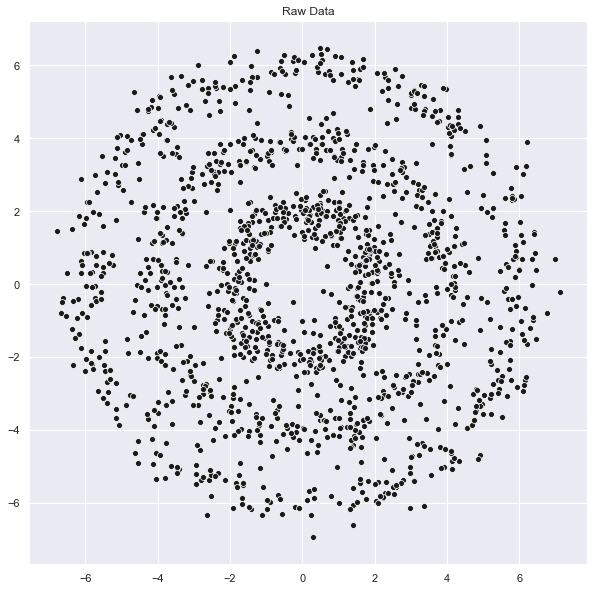

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(x=x1, y=y1, ax=ax, color='k')
sns.scatterplot(x=x2, y=y2, ax=ax, color='k')
sns.scatterplot(x=x3, y=y3, ax=ax, color='k')

ax.set(title='Raw Data');

## Add Labeled Data 

Now we generate some labeled samples:

In [5]:
# Set number of labeled samples per class
n_c_ex = 20
# Total number og labeled samples. 
n_ex = n_c*n_c_ex
# Generate labeled data.
q1, p1 = generate_circle_sample_data(2, n_c_ex, sigma)
q2, p2 = generate_circle_sample_data(4, n_c_ex, sigma)
q3, p3 = generate_circle_sample_data(6, n_c_ex, sigma)

Let us plet the complete data set:

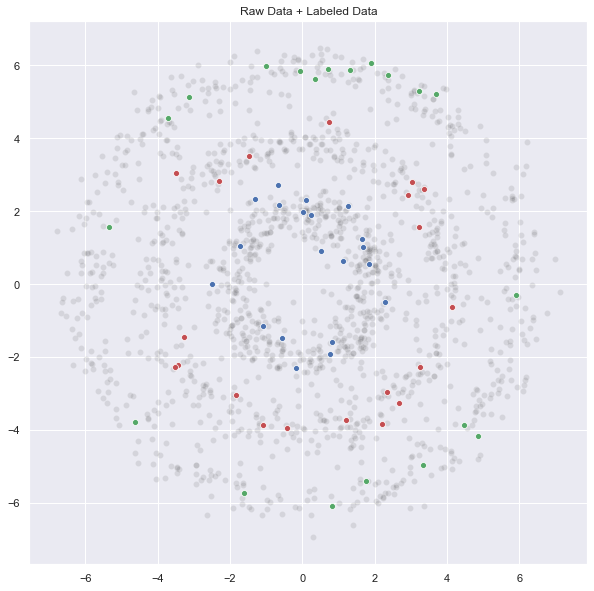

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(x=x1, y=y1, ax=ax, color='k', alpha=0.1)
sns.scatterplot(x=x2, y=y2, ax=ax, color='k', alpha=0.1)
sns.scatterplot(x=x3, y=y3, ax=ax, color='k', alpha=0.1)

sns.scatterplot(x=q1, y=p1, ax=ax, color='b')
sns.scatterplot(x=q2, y=p2, ax=ax, color='r')
sns.scatterplot(x=q3, y=p3, ax=ax, color='g')

ax.set(title='Raw Data + Labeled Data');

In [7]:
# Merge Data  
x = np.concatenate([x1, x2, x3, q1, q2, q3]).reshape(-1, 1)
y = np.concatenate([y1, y2, y3, p1, p2, p3]).reshape(-1, 1)

data_matrix = np.concatenate([x, y], axis=1)

Le tus compute the total number of points in the data set:

In [8]:
n = data_matrix.shape[0]
n

1560

In [9]:
# Common sense check:
n == n_c*(n_c_samples + n_c_ex)

True

## Generate Adjacency Matrix

In [10]:
from sklearn.neighbors import kneighbors_graph

# Set nearest neighbors used to compute the graph.
nn = 7
# We store the as a sparse matriix.
adjacency_matrix_s = kneighbors_graph(X=data_matrix,n_neighbors=nn)

Let us plot the adjacency_matrix:

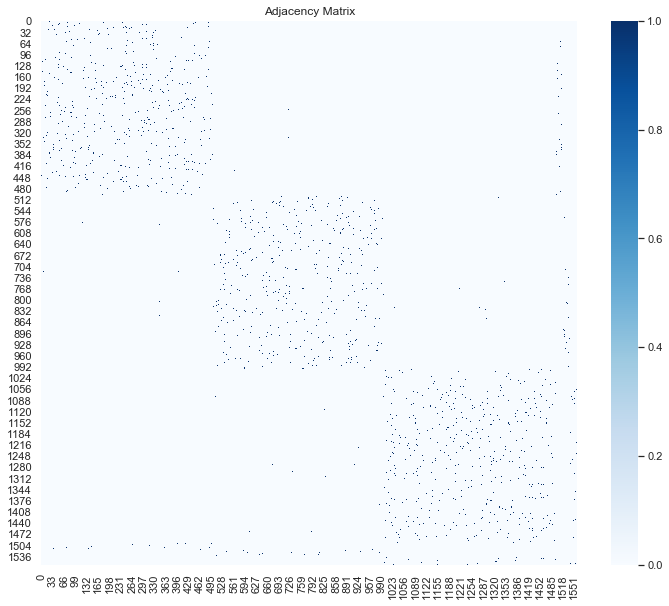

In [11]:
from scipy import sparse

# Conver to numpy array'
adjacency_matrix = adjacency_matrix_s.toarray()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(adjacency_matrix, ax=ax, cmap='Blues')
ax.set(title='Adjacency Matrix');

As the data was not not shuffled, we can see the "cluster" block. We also see the three small groups of labeled data.

## Generate Graph Laplacian

In [12]:
graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)

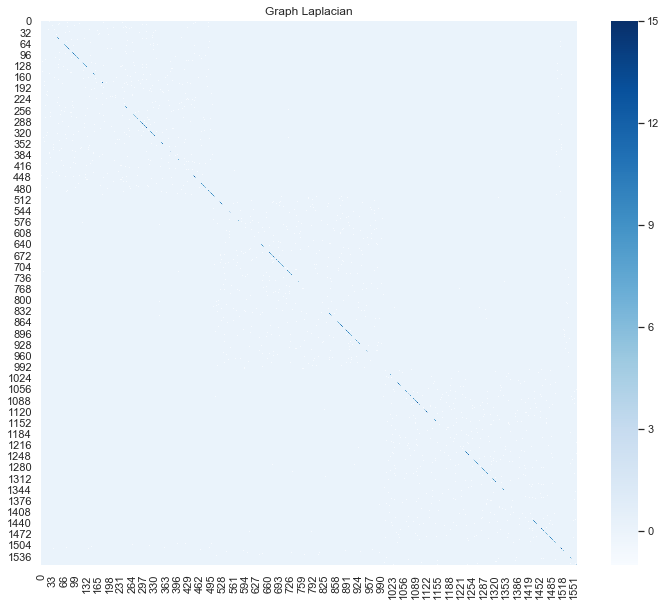

In [13]:
graph_laplacian = graph_laplacian_s.toarray()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(graph_laplacian, ax=ax, cmap='Blues')
ax.set(title='Graph Laplacian');

## Learning Problem Description

Plase refer to the [slides](https://github.com/eldadHaber/CompAI/blob/master/02-SemiSup.pdf) of [Eldad Haber](https://eldad-haber.webnode.com/) for details. Recall that the loss function we want to minimize is: 

$$
\min_{U}\mathcal{E}(U) = \min_{U} \left(\text{loss}(U, U_{obs}) + \frac{\alpha}{2} \text{tr}(U^T L U)\right)
$$

## Construct Loss Function

- One-Hot Encoding of the labels

In [14]:
u_obs = np.zeros(shape=(n_ex, n_c))

u_obs[0:n_c_ex, 0] = 1
u_obs[n_c_ex:2*n_c_ex, 1] = 1
u_obs[2*n_c_ex:3*n_c_ex, 2] = 1

In [15]:
# Get index of labeled data.
label_index = np.arange(start=n_c*n_c_samples, stop=n)

In [16]:
# We define a function to project onto the labeled labels.
def project_to_labeled(u, label_index):
    
    return u[label_index, :]

- Softmax Loss

In [17]:
from scipy.special import softmax

def sofmax_loss(c, c_obs):
    
    m = c.shape[0]
    
    soft_max = np.apply_along_axis(softmax, axis=1, arr=c)
    # Add small epsilon for numerical stability.
    loss = - (1/m)*np.dot(u_obs.T, np.log(soft_max + 0.001))

    loss = np.trace(loss)
    
    return loss

- Laplacian Loss

In [18]:
def laplacial_loss(c, graph_laplacian):
    
    loss = 0.5*np.dot(c.T, np.dot(graph_laplacian, c))
    
    loss = np.trace(loss)
    
    return loss

In [19]:
def loss(u, u_obs, label_index, graph_laplacian, alpha):
    
    u_proj = project_to_labeled(u, label_index)
    
    loss = sofmax_loss(u_proj, u_obs) + (alpha/2)*laplacial_loss(u, graph_laplacian)
    
    return loss

## Run Optimizer

In [20]:
from scipy.optimize import minimize

# Define iniitial estimate.
u0 = np.ones(shape=(n, n_c)) / 0.5

# Run optimizer.
optimizer_result = minimize(
    fun = lambda x: loss(x.reshape(n, n_c), u_obs, label_index, graph_laplacian, 1.0), 
    x0=u0.flatten()
)

## Predict Classes 

In [21]:
# Get best parameter. 
u_best = optimizer_result.x.reshape(n, n_c) 
# Compute classes 
u_best_softmax = np.apply_along_axis(softmax, axis=1, arr=u_best)
u_pred = np.argmax(a=u_best_softmax, axis=1)

In [22]:
import pandas as pd

data_df = pd.DataFrame(data_matrix, columns=['x', 'y'])

# Add one to have class labels starting form one. 
data_df['pred_class'] = u_pred + 1
# Store as categorical variable. 
data_df['pred_class'] = data_df['pred_class'].astype('category')

data_df.head()

,x,y,pred_class
0,0.351891,1.541491,1
1,2.324695,-1.179900,1
2,1.247323,-1.771348,1
3,-2.065666,-0.178555,1
4,1.743751,-0.867510,1


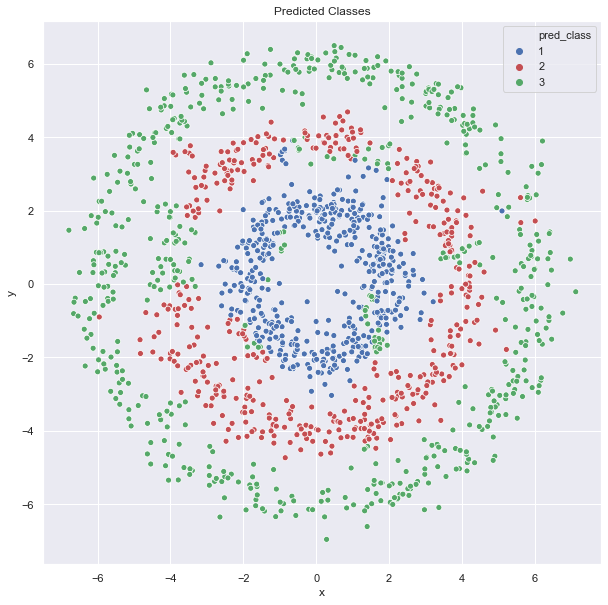

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='x', y='y', hue='pred_class', data=data_df, palette=['b', 'r', 'g'])
ax.set(title='Predicted Classes');

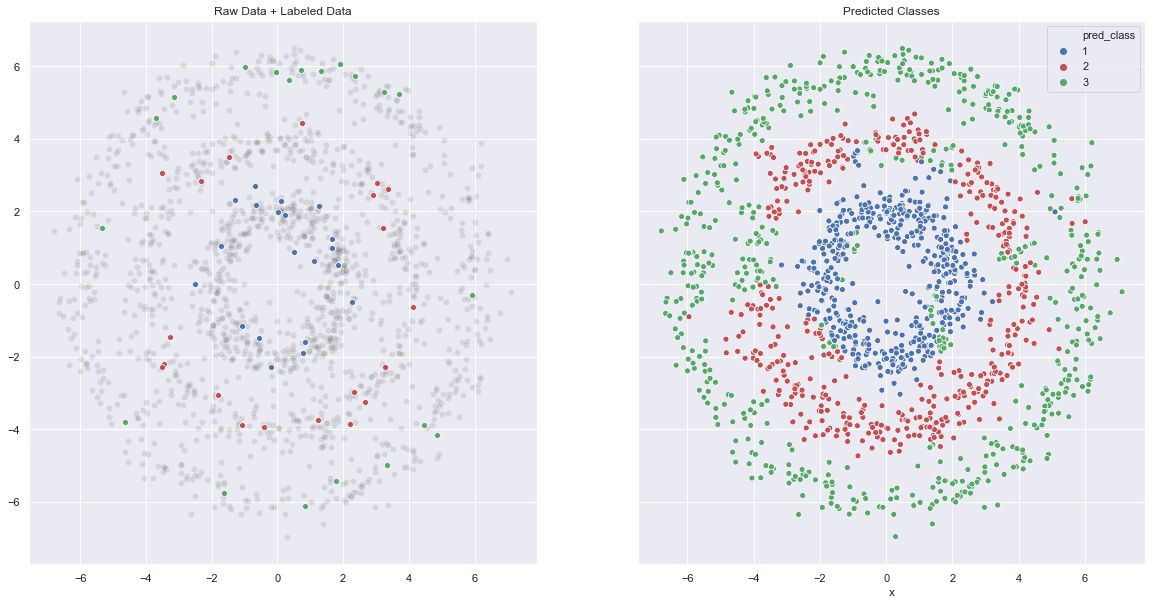

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(20, 10))

sns.scatterplot(x=x1, y=y1, ax=ax1, color='k', alpha=0.1)
sns.scatterplot(x=x2, y=y2, ax=ax1, color='k', alpha=0.1)
sns.scatterplot(x=x3, y=y3, ax=ax1, color='k', alpha=0.1)

sns.scatterplot(x=q1, y=p1, ax=ax1, color='b')
sns.scatterplot(x=q2, y=p2, ax=ax1, color='r')
sns.scatterplot(x=q3, y=p3, ax=ax1, color='g')

ax1.set(title='Raw Data + Labeled Data');

sns.scatterplot(x='x', y='y', hue='pred_class', data=data_df, palette=['b', 'r', 'g'], ax=ax2)
ax2.set(title='Predicted Classes');